In [1]:
import jupyter_black

import os, sys
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader

from PIL import Image

if not "/usr/src" in sys.path:
    sys.path.append("/usr/src")

jupyter_black.load()

In [31]:
# Custom modules
from dataset import create_cell_dataset, augmentation_cells
from unet import UNet
from diffusion import Diffusion
from utils_diffusion import (
    train,
    count_fid_metric,
    show_grid_samples,
    generate_and_save_samples,
    create_animation,
)

In [3]:
# Dirs
cell_dir = "/usr/src/data/separated_cells"
new_cell_dir = "/usr/src/data/separated_cells_new"
sample_dir = "/usr/src/samples_cell"

In [5]:
# Expanding of cell dataset using transforms
augmentation_cells(cell_dir, new_cell_dir)

In [6]:
# Settings
image_size = 64
channels = 1
batch_size = 70
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create the dataset of cells
cell_dataset = create_cell_dataset(new_cell_dir, image_size)

# Create the dataloader for training
train_loader = DataLoader(cell_dataset, batch_size=batch_size, shuffle=True)

In [7]:
# Check dataset and trainloader

print(f"Len of dataset:  {len(cell_dataset)} images")
print(f"Len of trainloader:  {len(train_loader)} batches")
print(f"Shape of batch:  {next(iter(train_loader)).shape}")

Len of dataset:  7640 images
Len of trainloader:  110 batches
Shape of batch:  torch.Size([70, 1, 64, 64])


In [15]:
# Initialization of the diffusion

timesteps = 400
diffusion = Diffusion(timesteps)

In [16]:
# Initialization of the denoising model

model = UNet(
    img_dim=image_size,
    img_channels=channels,
    in_channels=32,
    channel_mults=(1, 2, 4, 8),
)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [17]:
# Training model

epochs = 22
log_path = "logging_cells"
log_interval = len(train_loader) // 4

loss_progress = train(
    model,
    diffusion,
    timesteps,
    train_loader,
    epochs,
    optimizer,
    device,
    log_path,
    log_interval,
)

----- Epoch 1 -----
Loss: 0.5453195571899414
Loss: 0.06966577470302582
Loss: 0.05043421685695648
Loss: 0.030592462047934532
Loss: 0.0296009574085474


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 2 -----
Loss: 0.022830693051218987
Loss: 0.020268622785806656
Loss: 0.02168421633541584
Loss: 0.01839601807296276
Loss: 0.016838040202856064


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 3 -----
Loss: 0.010657565668225288
Loss: 0.020544767379760742
Loss: 0.01596563123166561
Loss: 0.018381480127573013
Loss: 0.011455439031124115


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 4 -----
Loss: 0.013454689644277096
Loss: 0.013603542931377888
Loss: 0.01687248796224594
Loss: 0.011719660833477974
Loss: 0.008712531998753548


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 5 -----
Loss: 0.010505253449082375
Loss: 0.015453253872692585
Loss: 0.01724545657634735
Loss: 0.012691608630120754
Loss: 0.010498435236513615


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 6 -----
Loss: 0.011743564158678055
Loss: 0.012561692856252193
Loss: 0.009861087426543236
Loss: 0.012465291656553745
Loss: 0.011887249536812305


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 7 -----
Loss: 0.012052684091031551
Loss: 0.01015407219529152
Loss: 0.017957987263798714
Loss: 0.01406739093363285
Loss: 0.00924269761890173


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 8 -----
Loss: 0.009467418305575848
Loss: 0.00820563081651926
Loss: 0.008248771540820599
Loss: 0.010707647539675236
Loss: 0.008900283835828304


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 9 -----
Loss: 0.016496991738677025
Loss: 0.008060198277235031
Loss: 0.010226910933852196
Loss: 0.00902412086725235
Loss: 0.011431875638663769


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 10 -----
Loss: 0.0065072583965957165
Loss: 0.007598711643368006
Loss: 0.011650270782411098
Loss: 0.012425948865711689
Loss: 0.00761006074026227


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 11 -----
Loss: 0.012995973229408264
Loss: 0.013682471588253975
Loss: 0.010569341480731964
Loss: 0.00964801013469696
Loss: 0.011438963934779167


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 12 -----
Loss: 0.009818535298109055
Loss: 0.013398959301412106
Loss: 0.006713156122714281
Loss: 0.007673848420381546
Loss: 0.008089907467365265


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 13 -----
Loss: 0.010165541432797909
Loss: 0.010417346842586994
Loss: 0.009655976668000221
Loss: 0.010138256475329399
Loss: 0.010994517244398594


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 14 -----
Loss: 0.009733714163303375
Loss: 0.008781983517110348
Loss: 0.01073751412332058
Loss: 0.010443484410643578
Loss: 0.008386719040572643


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 15 -----
Loss: 0.008889253251254559
Loss: 0.008056473918259144
Loss: 0.011101697571575642
Loss: 0.009799398481845856
Loss: 0.011969531886279583


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 16 -----
Loss: 0.007243541534990072
Loss: 0.009380705654621124
Loss: 0.006471205037087202
Loss: 0.009218051098287106
Loss: 0.010044381953775883


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 17 -----
Loss: 0.007372910622507334
Loss: 0.009006164968013763
Loss: 0.010679683648049831
Loss: 0.0120657654479146
Loss: 0.0075708781369030476


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 18 -----
Loss: 0.015981223434209824
Loss: 0.008337846025824547
Loss: 0.013716813176870346
Loss: 0.006008189171552658
Loss: 0.00785310659557581


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 19 -----
Loss: 0.008969130925834179
Loss: 0.007288250140845776
Loss: 0.009581678546965122
Loss: 0.006205173674970865
Loss: 0.009344479069113731


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 20 -----
Loss: 0.007440801244229078
Loss: 0.008526885882019997
Loss: 0.008526531048119068
Loss: 0.008383418433368206
Loss: 0.007449592929333448


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 21 -----
Loss: 0.008815951645374298
Loss: 0.008836102671921253
Loss: 0.006593852303922176
Loss: 0.007719450164586306
Loss: 0.006735685281455517


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 22 -----
Loss: 0.009693879634141922
Loss: 0.007329012732952833
Loss: 0.007731723133474588
Loss: 0.010204391553997993
Loss: 0.006983908824622631


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

Total training time = 279.029 sec


Text(0.5, 1.0, 'Loss per each step')

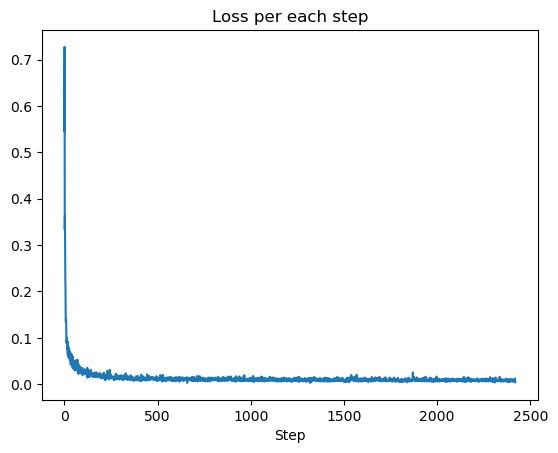

In [18]:
plt.plot(loss_progress)
plt.xlabel("Step")
plt.title("Loss per each step")

In [26]:
# Save trained model

torch.save(model, f"cell_ddpm_{timesteps}_steps_{epochs}_epochs.pt")

In [ ]:
# Load pretrained model

model = torch.load("cell_ddpm_400_steps_25_epochs.pt")
model.eval()

sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

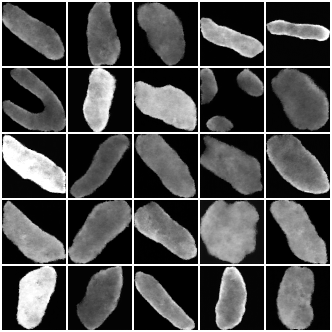

In [30]:
# Create grid of generated samples and show it

samples = show_grid_samples(25, diffusion, model, image_size, channels, "grid_cells")

In [ ]:
# Create animation for one cell
create_animation("denoising_cell", samples, -3, timesteps)

In [9]:
# Generate many new separate samples and save them

generate_and_save_samples(sample_dir, 20, 20, diffusion, model, image_size, channels)

sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

In [25]:
# Count FID metric

feature = 2048
print(
    f"feature = {feature}, FID =",
    count_fid_metric(
        train_loader, diffusion, model, image_size, channels, 500, feature
    ),
)

sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

560 samples are generated, time = 101.304 sec
FID is computed, time = 135.407 sec
feature = 2048, FID = tensor(139.3082)
